In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from config import GOOGLE_PATH, WEATHER_PATH, POP_PATH, FLU_PATH
import json
from datetime import datetime

In [45]:
# Import data
flu = pd.read_csv('../data/INFLUENZA_sentinella/data.csv')
weather = pd.read_csv('../data/weather/reg_weather.csv')
google_flu = pd.read_csv('../data/google_search_trend/reg_google_grippe.csv')
google_symptoms = pd.read_csv('../data/google_search_trend/reg_google_fieber_husten.csv')
pop = pd.read_csv('../data/pop_data_cantons/weekly_imputed_pop_data_final.csv')

<h3>Data Preparation</h3>

In [46]:
# Create dataframe for country-level observations, no differentiation between sex or age
flu_CH = flu.query('georegion_type == "country" and agegroup == "all" and sex == "all"').copy()

# Create dataframe for regional observations, no differentiation between sex or age
flu_reg = flu.query('georegion_type == "sentinella_region" and agegroup == "all" and sex == "all"').copy()

# Drop unknown region entries from flu_region using mask
flu_reg = flu_reg[~(flu_reg['georegion'] == 'unknown')]

# Select columns required for analysis
selected_cols = ['temporal', 'georegion', 'popExtrapolation', 'incValue']
flu_reg = flu_reg[selected_cols]
flu_reg.rename(columns={'popExtrapolation':'flu_cases'}, inplace=True)

In [47]:
# Align time-indexes of google data and flu data
with open('date_dict.json', 'r') as f:
    date_dict = json.load(f)

google_flu['Woche'] = google_flu['Woche'].apply(lambda x: date_dict[x])
google_symptoms['Woche'] = google_symptoms['Woche'].apply(lambda x: date_dict[x])

In [48]:
dates = weather.date.values
# Convert dates to 'YYYY-Www' ISO week format
iso_week_dates = [datetime.strptime(date, '%Y-%m-%d').isocalendar()[:2] for date in dates]
iso_week_dates = [f'{year}-W{week:02d}' for year, week in iso_week_dates]
weather['date'] = iso_week_dates

In [49]:
# Reshape google_flu from wide to long
google_flu = google_flu.melt(id_vars=['Woche'], var_name='region_query', value_name='search_activity')

# Separate region and query information from header into separate rows
google_flu['region'] = google_flu['region_query'].apply(lambda x: "_".join(x.split('_')[:2]))
google_flu['query'] = google_flu['region_query'].apply(lambda x: "_".join(x.split('_')[2:]))
google_flu.drop(columns='region_query', inplace=True) # Drop superfluous region_query column

# Reshape dataframe to get separate columns for each variable
google_flu = google_flu.pivot(index=['Woche', 'region'], columns='query', values='search_activity').reset_index()

In [50]:
# Reshape google_flu from wide to long
google_symptoms = google_symptoms.melt(id_vars=['Woche'], var_name='region_query', value_name='search_activity')

# Separate region and query information from header into separate rows
google_symptoms['region'] = google_symptoms['region_query'].apply(lambda x: "_".join(x.split('_')[:2]))
google_symptoms['query'] = google_symptoms['region_query'].apply(lambda x: "_".join(x.split('_')[2:]))
google_symptoms.drop(columns='region_query', inplace=True) # Drop superfluous region_query column

# Reshape dataframe to get separate columns for each variable
google_symptoms = google_symptoms.pivot(index=['Woche', 'region'], columns='query', values='search_activity').reset_index()

In [51]:
pop

,Kanton,Bevölkerung 1. Januar,Geburten,Todesfälle,Überschuss,Wanderungssaldo international 1,Wanderungssaldo interkantonal,Bevölkerung 31. Dezember,total,% over Year,...,Ausserhalb des Einflusses städtischer Kerne,BIP in Millionen CHF,BIP Growth Laufende Preise,BIP Growth Preise Vorjahr,BIP pro Kopf,Woche,Bevölkerung,% over week,Jahr-Woche,Pop Density
0,Aargau,627340,124.0,88.0,36.0,95.0,47.0,636362,174.0,1.438136,...,93486.0,41229.16645,2.28242,1.93227,64788.856736,1,6.273400e+05,NaN,2013-W01,446.823362
1,Aargau,627340,124.0,88.0,36.0,95.0,47.0,636362,174.0,1.438136,...,93512.0,41229.16645,2.28242,1.93227,64788.856736,2,6.275169e+05,0.028199,2013-W02,446.949360
2,Aargau,627340,124.0,88.0,36.0,95.0,47.0,636362,174.0,1.438136,...,93538.0,41229.16645,2.28242,1.93227,64788.856736,3,6.276938e+05,0.028191,2013-W03,447.075359
3,Aargau,627340,124.0,88.0,36.0,95.0,47.0,636362,174.0,1.438136,...,93565.0,41229.16645,2.28242,1.93227,64788.856736,4,6.278707e+05,0.028183,2013-W04,447.201357
4,Aargau,627340,124.0,88.0,36.0,95.0,47.0,636362,174.0,1.438136,...,93591.0,41229.16645,2.28242,1.93227,64788.856736,5,6.280476e+05,0.028175,2013-W05,447.327356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14089,Zürich,1564662,297.0,232.0,65.0,315.0,-68.0,1579967,294.0,0.978167,...,10401.0,NaN,NaN,NaN,NaN,48,1.578767e+06,0.019012,2022-W48,913.109663
14090,Zürich,1564662,297.0,232.0,65.0,315.0,-68.0,1579967,294.0,0.978167,...,10403.0,NaN,NaN,NaN,NaN,49,1.579067e+06,0.019008,2022-W49,913.283231
14091,Zürich,1564662,297.0,232.0,65.0,315.0,-68.0,1579967,294.0,0.978167,...,10405.0,NaN,NaN,NaN,NaN,50,1.579367e+06,0.019005,2022-W50,913.456798
14092,Zürich,1564662,297.0,232.0,65.0,315.0,-68.0,1579967,294.0,0.978167,...,10407.0,NaN,NaN,NaN,NaN,51,1.579667e+06,0.019001,2022-W51,913.630366


In [52]:
merged_data = pd.merge(flu_reg, weather, how='left', left_on=['temporal', 'georegion'], right_on=['date', 'region']).sort_values(by=['georegion', 'temporal'])
merged_google = pd.merge(google_flu, google_symptoms, how='inner', on=['region', 'Woche'])
merged_data = pd.merge(merged_data, merged_google, how='left', left_on=['georegion', 'temporal'], right_on=['region', 'Woche'])

In [53]:
merged_data.columns

Index(['temporal', 'georegion', 'flu_cases', 'incValue', 'region_x', 'date',
       'weighted_avg_daily_temp', 'weighted_avg_daily_hum',
       'weighted_max_daily_temp', 'weighted_min_daily_temp',
       'weighted_max_daily_hum', 'weighted_min_daily_hum', 'Woche', 'region_y',
       'Flu', 'Flu_resid', 'Flu_seasonal', 'Flu_trend', 'Grippe',
       'Grippe_resid', 'Grippe_seasonal', 'Grippe_trend', 'Influenza',
       'Influenza_resid', 'Influenza_seasonal', 'Influenza_trend', 'influenza',
       'influenza_resid', 'influenza_seasonal', 'influenza_trend', 'Fieber',
       'Fieber_resid', 'Fieber_seasonal', 'Fieber_trend', 'fièvre',
       'fièvre_resid', 'fièvre_seasonal', 'fièvre_trend', 'husten',
       'husten_resid', 'husten_seasonal', 'husten_trend', 'toux', 'toux_resid',
       'toux_seasonal', 'toux_trend'],
      dtype='object')

In [54]:
merged_data.drop(columns=['region_x', 'region_y', 'date', 'Woche'], inplace=True)

In [55]:
import datetime

# Functions taken from: https://stackoverflow.com/questions/304256/whats-the-best-way-to-find-the-inverse-of-datetime-isocalendar
def iso_year_start(iso_year):
    "The gregorian calendar date of the first day of the given ISO year"
    fourth_jan = datetime.date(iso_year, 1, 4)
    delta = datetime.timedelta(fourth_jan.isoweekday()-1)
    return fourth_jan - delta 

def iso_to_gregorian(iso_year, iso_week, iso_day):
    "Gregorian calendar date for the given ISO year, week and day"
    year_start = iso_year_start(iso_year)
    return year_start + datetime.timedelta(days=iso_day-1, weeks=iso_week-1)


In [56]:
# Define the regex pattern
pattern = r'W(\d{1,2})'

# Extract week number and year and convert to integer
merged_data['week_number'] = merged_data['temporal'].str.extract(pattern).astype(int)

merged_data['year'] = merged_data['temporal'].apply(lambda x: x.split('-')[0])
merged_data['year'] = pd.to_numeric(merged_data['year'])

# Convert from iso-calendar week to dates
merged_data['date'] = list(map(lambda year, week: iso_to_gregorian(year, week, 4), merged_data['year'], merged_data['week_number']))

In [68]:
merged_data.set_index('date', inplace=True)

In [69]:
# Impute missing values in March 2020 linearly
merged_data['incValue'].interpolate(inplace=True)

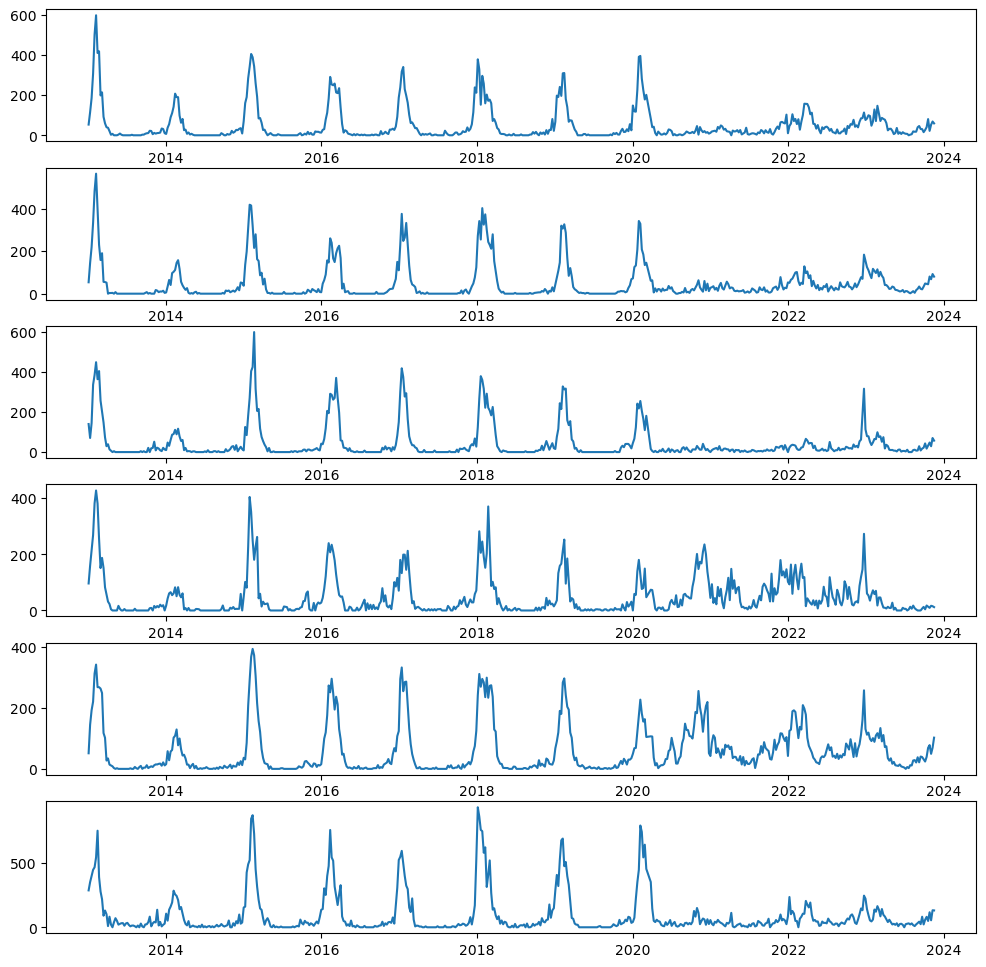

In [70]:
fig, ax = plt.subplots(6, figsize=(12, 12))
for i in range(1, 7):
    ax[i-1].plot(merged_data.loc[merged_data['georegion'] == f"region_{i}", 'incValue'])

<h3>Feature Engineering</h3>

In [15]:
def create_lagged_features(df, column, number_of_lags=4):
    # Group by 'georegion' and apply the lagging within each group
    new_df = df.groupby('georegion', group_keys=False).apply(lambda group: group.assign(
        **{f'lag_{i}': group[column].shift(i) for i in range(1, number_of_lags + 1)}
    ))

    # Reset index to flatten the dataframe structure after grouping
    new_df.reset_index(drop=True, inplace=True)

    return new_df

# Create lagged features
df_lagged = create_lagged_features(merged_data, column='flu_cases', number_of_lags=10)

# Drop rows with NaN values (due to lagging)
df_lagged.dropna(inplace=True)

In [16]:
df_lagged.sort_values(by=['georegion', 'temporal'])

,temporal,georegion,flu_cases,incValue,weighted_avg_daily_temp,weighted_avg_daily_hum,weighted_max_daily_temp,weighted_min_daily_temp,weighted_max_daily_hum,weighted_min_daily_hum,...,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
10,2013-W11,region_1,35830.0,92.10,3.041126,64.027594,7.018732,-0.632312,81.997623,43.954862,...,33656.1,34254.9,32491.9,36076.5,40782.5,39004.7,36421.1,37204.9,33045.6,16876.1
11,2013-W12,region_1,36919.6,59.59,5.351498,71.945642,9.155251,1.765799,90.831871,50.519858,...,35830.0,33656.1,34254.9,32491.9,36076.5,40782.5,39004.7,36421.1,37204.9,33045.6
12,2013-W13,region_1,29930.4,40.09,3.761392,81.351220,6.519214,1.699399,91.306503,67.184987,...,36919.6,35830.0,33656.1,34254.9,32491.9,36076.5,40782.5,39004.7,36421.1,37204.9
13,2013-W14,region_1,23935.8,37.60,5.961335,67.501318,10.141658,2.485400,84.755874,48.880789,...,29930.4,36919.6,35830.0,33656.1,34254.9,32491.9,36076.5,40782.5,39004.7,36421.1
14,2013-W15,region_1,33698.8,20.77,9.715740,70.907399,15.208568,5.266125,91.921445,45.678236,...,23935.8,29930.4,36919.6,35830.0,33656.1,34254.9,32491.9,36076.5,40782.5,39004.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3379,2023-W18,region_6,13680.1,21.93,14.939863,67.277623,20.080837,10.631480,90.256137,44.080142,...,12755.9,17202.9,7426.8,14459.1,13252.0,13478.2,14203.4,15398.5,14717.9,9812.5
3380,2023-W19,region_6,14985.0,26.69,12.484502,81.365646,16.467443,10.039742,95.725453,61.647225,...,13680.1,12755.9,17202.9,7426.8,14459.1,13252.0,13478.2,14203.4,15398.5,14717.9
3381,2023-W20,region_6,10567.8,18.93,13.802783,67.059148,17.759773,10.523481,88.191809,46.933802,...,14985.0,13680.1,12755.9,17202.9,7426.8,14459.1,13252.0,13478.2,14203.4,15398.5
3382,2023-W21,region_6,13056.7,30.64,16.966840,70.844560,22.765740,12.086358,93.296484,46.150461,...,10567.8,14985.0,13680.1,12755.9,17202.9,7426.8,14459.1,13252.0,13478.2,14203.4


<h3>Model Training</h3>

In [15]:
# Define features and target variable
X = df_lagged.drop('flu_cases', axis=1).values  # Features (including lagged flu cases)
y = df_lagged['flu_cases'].values  # Target

# Split the data (80%-20% split for example)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]